In [5]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import uniform, exponential
import numpy as np
import pandas as pd
import seaborn as sb
from lifelines.utils import survival_table_from_events
from lifelines.plotting import plot_lifetimes

## plot/figure defaults
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['figure.titlesize'] = 'large'


# Survival Modeling in Stan

 -- TODO insert image here 
 

# a very brief introduction

Survival analysis typically involves **time to event** as the outcome of interest

Typical applications include:
* biomedical research (time to clinical event or death)
* digital marketing (time to click or KPI)
* machine (time to mechanical failure)
* psychology (e.g. studies of delayed gratification)
* ... etc


## key terms
* censoring: when an event isn't observed, but we know 
   - it happened after time `b` (right censoring)
   - it happened before time `a` (left censoring)
   - it happened between times `a` and `b` (interval censoring)

Survival analysis typically makes an assumption of *non-informative censoring*. 

If this assumption holds, it means that the true event time (if it were to be observed) is unrelated to the censored time.

In a context of a well-designed clinical trial, this assumption is addressed by the study design which imposes an independent censoring process. 

For example, it's not uncommon for follow-up time to be truncated after a predetermined time $t=10$ for all patients.

In [2]:
# (prep for example - borrowed from http://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html)
from numpy.random import uniform, exponential
import numpy as np

## example of censored data
from lifelines.plotting import plot_lifetimes
def plot_example():
    N = 25
    current_time = 10

    actual_lifetimes = np.array([[exponential(12), exponential(5)][uniform()<0.3] for i in range(N)])
    observed_lifetimes = np.minimum(actual_lifetimes, current_time)
    observed = actual_lifetimes < current_time
    fig = plt.figure()
    _ = plt.xlim(0, 25)
    _ = plt.vlines(10, 0, 30, lw=2, linestyles="--")
    _ = plt.xlabel('time')
    _ = plt.title('Births and deaths of a hypothetical population, censored at $t=10$', size=20)    
    _ = plot_lifetimes(lifetimes=observed_lifetimes, event_observed=observed)



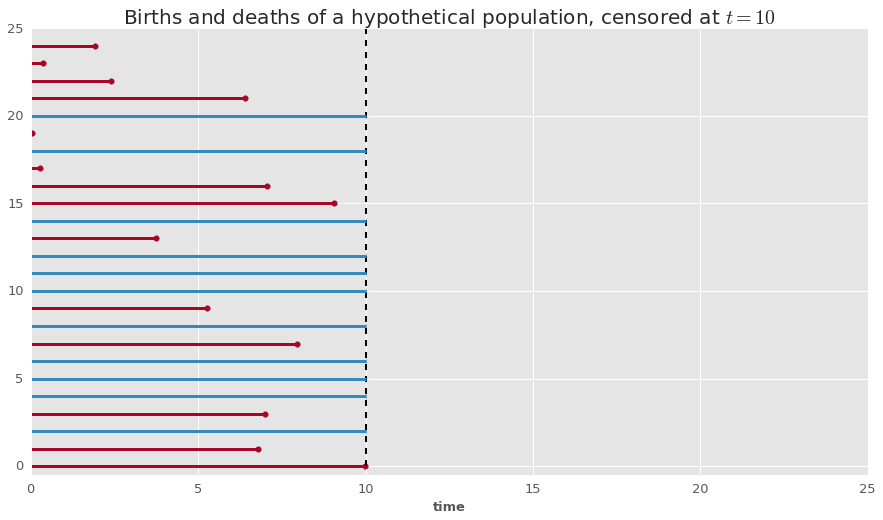

In [3]:
plot_example()

*however*, this assumption can sometimes be violated if, for example, less healthy patients are more likely to drop out of the study early.

## key terms (cont'd)

* failure event: the outcome event of interest
* survival: not failure
* hazard: risk for failure events

**Survival**

We first define a *Survival* function $S$ as the probability of surviving to time $t$:

  $$ S(t)=Pr(Y > t) $$

where $T$ is the true survival time.

**hazard**

We also define the instantaneous *hazard* function $\lambda$ as the probability of a failure event occuring in the interval [$t$, $t+\delta t$], given survival to time $t$:


  $$ \lambda(t) =  \lim_{\delta t \rightarrow 0 } \; \frac{Pr( t \le Y \le t + \delta t | Y > t)}{\delta t} $$

Which is equal to 

  $$ \lambda(t) = \frac{-S'(t)}{S(t)} $$

Solving this 

  $$ \lambda(t) = \frac{-S'(t)}{S(t)} $$
  
yields the following:

  $$ S(t) = \exp\left( -\int_0^t \lambda(z) dz \right) $$

which provides a useful way for us to switch from modeling *hazards* to modeling *Survival*.

The integral in this equation is also sometimes called the *cumulative hazard*, here noted as $H(t)$.

  $$ H(t) = \int_0^t \lambda(z) dz $$

It's worth pointing out that, by definition, the cumulative hazard (estimating $Pr(Y \lt t)$) is the complementary c.d.f of the Survival function (which estimates $Pr(Y \ge t)$).


Let's consider a simple *hazard* function $\lambda(t)$ as constant over time. 

  $$ \lambda(t) = a $$

Cumulative hazard ($H$) would be: 

  $$ H(t) = \int_0^t \lambda(z) dz = at $$

And the *Survival* function would be:

  $$ S(t) = \exp\left( -\int_0^t \lambda(z) dz \right) = \exp ( − a t ) $$



Graphically, this would look like the following: 

In [4]:
## prep example plot for hazard <> Survival curves
def plot_survival_exp(N, censor_time, rate):

    sample_data = pd.DataFrame({
            't': np.linspace(0, censor_time, num=N),
            })
    sample_data['hazard'] = rate
    sample_data['cum_hazard'] = rate*sample_data.t
    sample_data['Survival'] = np.exp(-1 * rate * sample_data.t)
    fig = plt.figure()
    _ = plt.subplot(131)
    _ = plt.plot(sample_data.t, sample_data.hazard, 'b')
    _ = plt.title('Hazard $\lambda(t)$', size=20)
    _ = plt.xlabel('time')
    _ = plt.subplot(132)
    _ = plt.plot(sample_data.t, sample_data.cum_hazard, 'r')
    _ = plt.title('Cum. hazard $H(t)$', size=20)
    _ = plt.xlabel('time')
    _ = plt.subplot(133)
    _ = plt.plot(sample_data.t, sample_data.Survival, 'g')
    _ = plt.title('Survival $S(t)$', size=20)
    _ = plt.xlabel('time')
    


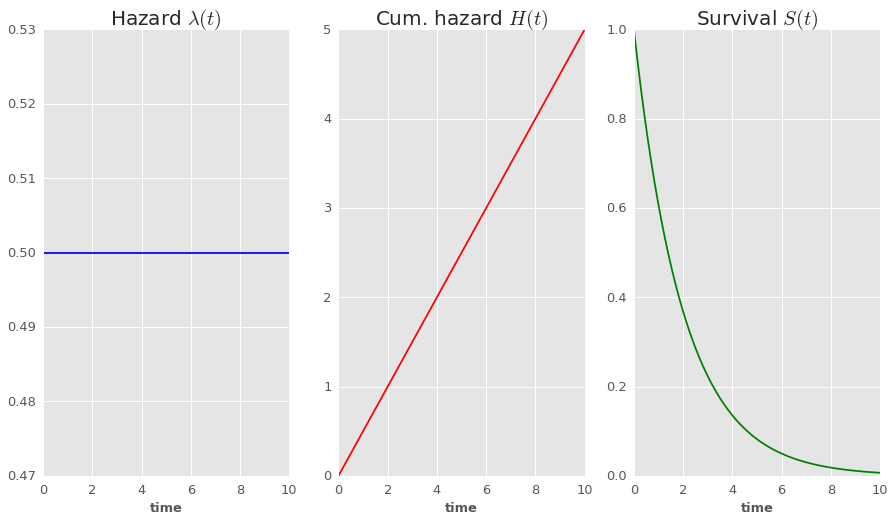

In [5]:
plot_survival_exp(N = 1000, censor_time = 10, rate = 0.5)

In [10]:
## prep simulate-data example under Exponential model
def plot_cum_survival(t, event):
    # at each time t, calculate the cumulative survival
    cum_survival = survival_table_from_events(t, event)
    cum_survival.reset_index(0, inplace=True)
    cum_survival.rename(columns = {'event_at': 't'}, inplace=True)
    cum_survival['Survival'] = cum_survival['at_risk']/max(cum_survival['at_risk'])
    # create figure
    fig = plt.figure()
    _ = plt.plot(cum_survival.t, cum_survival.Survival, 'rs')
    _ = plt.xlabel('time')
    return(cum_survival)


We can also simulate survival times for a population under this fairly simple model.

In [7]:
# define a function to simulate data
def simulate_exp_survival_data(N, censor_time, rate):
    ## simulate true lifetimes (t) according to exponential model
    sample_data = pd.DataFrame({
            'true_t': np.random.exponential((1/rate), size=N) 
            })
    ## censor observations at censor_time
    sample_data['t'] = np.minimum(sample_data['true_t'], censor_time)
    sample_data['event'] = sample_data['t'] >= sample_data['true_t']
    return(sample_data)

In [8]:
# simulate data assuming constant hazard over time of 0.5
df = simulate_exp_survival_data(N = 100, censor_time = 6, rate = 0.5)
df.head()

,true_t,t,event
0,0.137413,0.137413,True
1,4.310870,4.310870,True
2,1.685407,1.685407,True
3,2.228120,2.228120,True
4,0.632862,0.632862,True


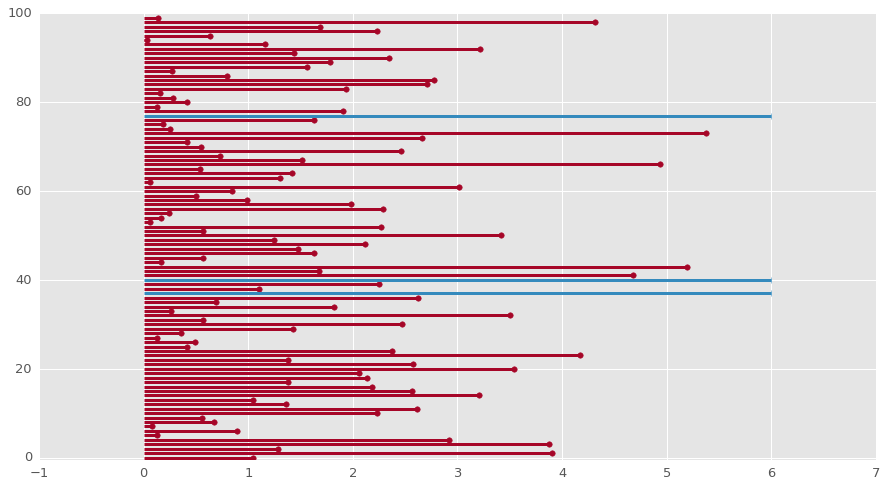

In [9]:
# plot lifelines for this simulated sample
plot_lifetimes(event_observed=df.event, lifetimes=df.t)

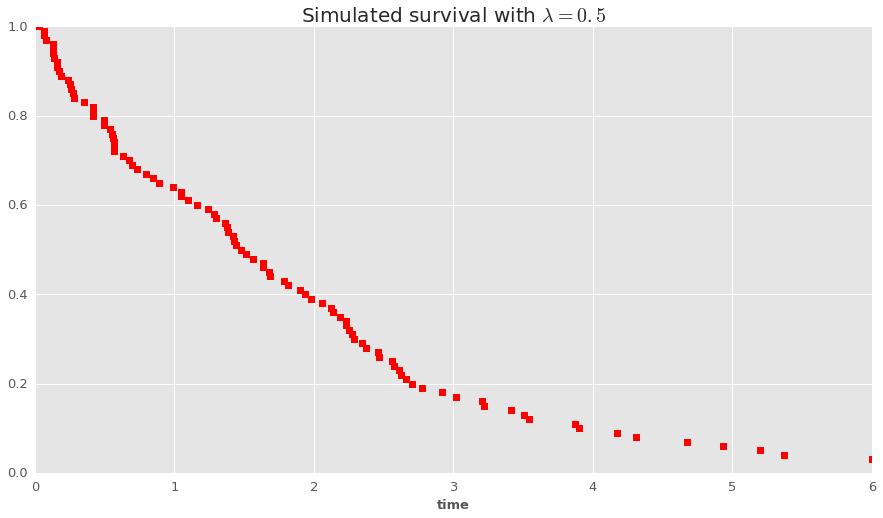

In [10]:
# calculate number of people surviving at each time T
# plot Survival to time t given simulated data
a = plot_cum_survival(df.t, df.event)
_ = plt.title('Simulated survival with $\lambda={}$'.format(0.5), size=20)    

Now, overlay computed Survival from simulated data with estimated c.d.f 

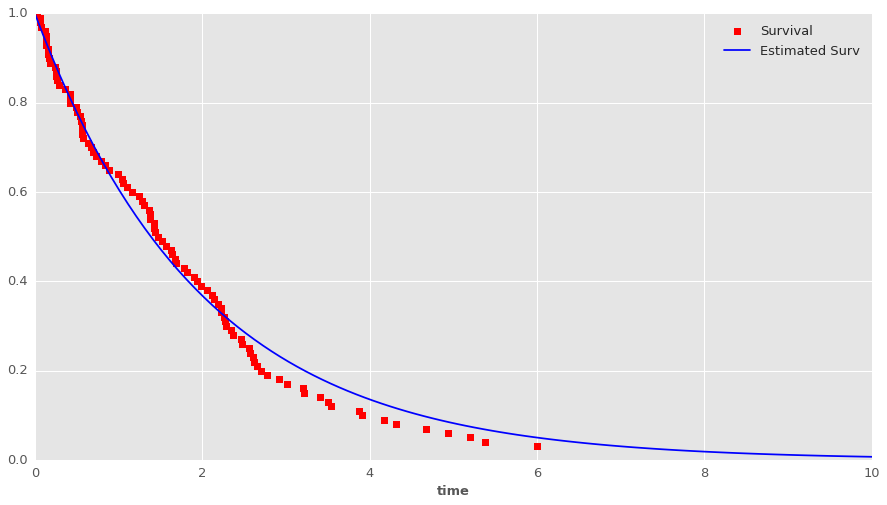

In [11]:
a = plot_cum_survival(df.t, df.event)
## overlay c.d.f. estimate as exp(-at)

test = pd.DataFrame([{
            't': t,
            'Estimated Surv': np.exp(-1 * 0.5 * t)
        } for t in np.linspace(0, 10, num=100)])
_ = plt.plot(test.t, test['Estimated Surv'], 'b')
_ = plt.legend()

# the likelihood

The data for survival analysis typically constitute a set of observed pairs: [`t`, `status`] for each subject, where 

* `t` is the survival time (last time a subject was observed alive)
* `status` is a binary (T/F or 1/0) indicator for whether the failure event occurred at time `t`.




The likelihood for an observation $i$ with time $t_i$ and `status = 1` (DECEASED) will reflect the joint probability of surviving to time $t$ and having an event at time $t$:

   $$ L_i = f(t_i) = S(t_i)\lambda(t_i) $$ 

For an observation that is censored at time $t$, we only have a contribution to the Survival function :

   $$ L_i = f(t_i) = S(t_i) $$ 



Most of the time, we are interested in modeling the impact of covariates on these outcomes. 

The typical starting point is to make what's called the *Proportional Hazards* assumption. 

IE: 

  $$ h_X(t_i) = e^{\beta X}h(t_i) $$
  




For example, in the context of our previous example of Survival times simulated according to the Exponential model, we have:

In [12]:
## prep simulate-data example under Exponential model
def plot_cum_survival_X(df):
    # at each time t, calculate the cumulative survival
    data_true = df.loc[df['X'] == True,]
    cumsurv_true = survival_table_from_events(data_true.t, data_true.event)
    cumsurv_true.reset_index(0, inplace=True)
    cumsurv_true['X'] = True
    cumsurv_true.rename(columns = {'event_at': 't'}, inplace=True)
    cumsurv_true['Survival'] = cumsurv_true['at_risk']/max(cumsurv_true['at_risk'])

    data_false = df.loc[df['X'] == False,]
    cumsurv_false = survival_table_from_events(data_false.t, data_false.event)
    cumsurv_false.reset_index(0, inplace=True)
    cumsurv_false['X'] = False
    cumsurv_false.rename(columns = {'event_at': 't'}, inplace=True)
    cumsurv_false['Survival'] = cumsurv_false['at_risk']/max(cumsurv_false['at_risk'])
    
    cum_survival = cumsurv_true.append(cumsurv_false)
    # create figure
    fig = plt.figure()
    _ = sb.lmplot(data = cum_survival, x='t', y='Survival', hue='X', fit_reg=False)

In [13]:
# define a function to simulate data
def simulate_exp_survival_data_X(N, censor_time, rate, beta):
    ## simulate true lifetimes (t) according to exponential model
    sample_data = pd.DataFrame({
            'X' : [np.random.uniform()>0.5 for n in np.zeros(N)],
            'baseline_hazard': np.repeat(rate, repeats=N),
            })
    sample_data['hazard'] = np.exp(beta*sample_data['X'])*sample_data['baseline_hazard']
    sample_data['true_t'] = sample_data.apply(lambda row: np.random.exponential(scale = 1/row['hazard']), axis = 1)
    ## censor observations at censor_time
    sample_data['t'] = np.minimum(sample_data['true_t'], censor_time)
    sample_data['event'] = sample_data['t'] >= sample_data['true_t']
    return(sample_data)

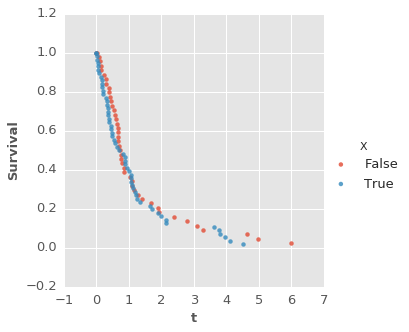

In [14]:
df = simulate_exp_survival_data_X(N=100, censor_time=6, rate=0.9, beta=0.2)
plot_cum_survival_X(df)

In [15]:
# fit exponential model to these data
import stanity
import survivalstan
models = survivalstan.utils.read_files('stan')

stan/exp_survival_model.stan
stan/pem_survival_model_unstructured.stan
stan/pem_survival_model_gamma.stan
stan/pem_survival_model_randomwalk_bspline_est_xi.stan
stan/pem_survival_model_randomwalk.stan
stan/pem_survival_model_randomwalk_bspline.stan
stan/weibull_survival_model.stan


In [16]:
weib_model = survivalstan.fit_stan_survival_model(df = df, 
                                                 formula = '~ X',
                                                 event_col = 'event',
                                                 time_col = 't',
                                                 model_code = survivalstan.models.weibull_survival_model,
                                                 chains = 4, 
                                                 iter = 5000,
                                                 make_inits = survivalstan.make_weibull_survival_model_inits,
                                                 model_cohort = 'exp simulated, weibull model'
                                                ) 

NOT reusing model.
Ran in 66.599 sec.


/mnt/ssd0/env/local/lib/python2.7/site-packages/stanity/psis.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif sort == 'in-place':
/mnt/ssd0/env/local/lib/python2.7/site-packages/stanity/psis.py:246: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bs /= 3 * x[sort[np.floor(n/4 + 0.5) - 1]]


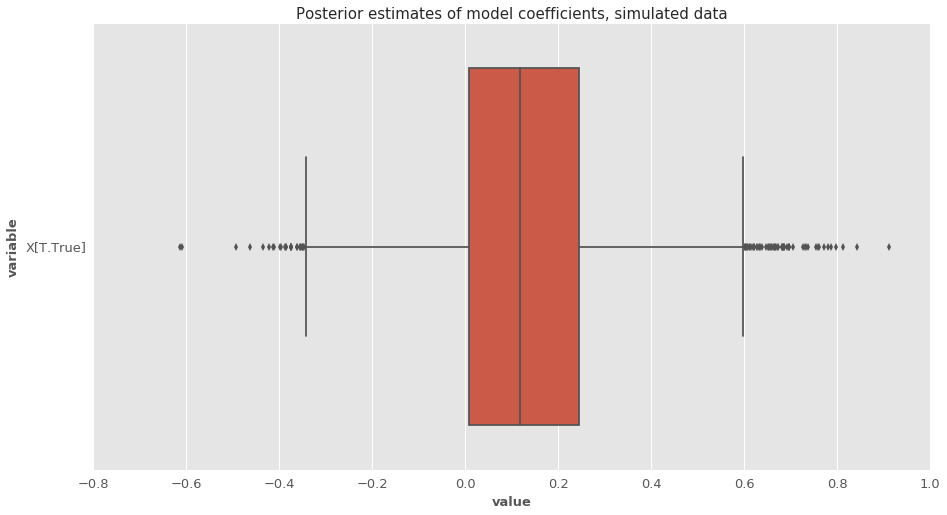

In [17]:
sb.boxplot(data=weib_model['coefs'], x = 'value', y = 'variable')
plt.title('Posterior estimates of model coefficients, simulated data', size = 15)

In [18]:
## try with exponential baseline hazard
exp_model = survivalstan.fit_stan_survival_model(df = df,
                         model_code = models['exp_survival_model.stan'],
                         formula = '~ X',
                         model_cohort = 'exp simulated, exp model',
                         event_col = 'event',
                         time_col = 't',
                         chains = 4, 
                         iter = 5000,
                         )

NOT reusing model.
Ran in 55.863 sec.


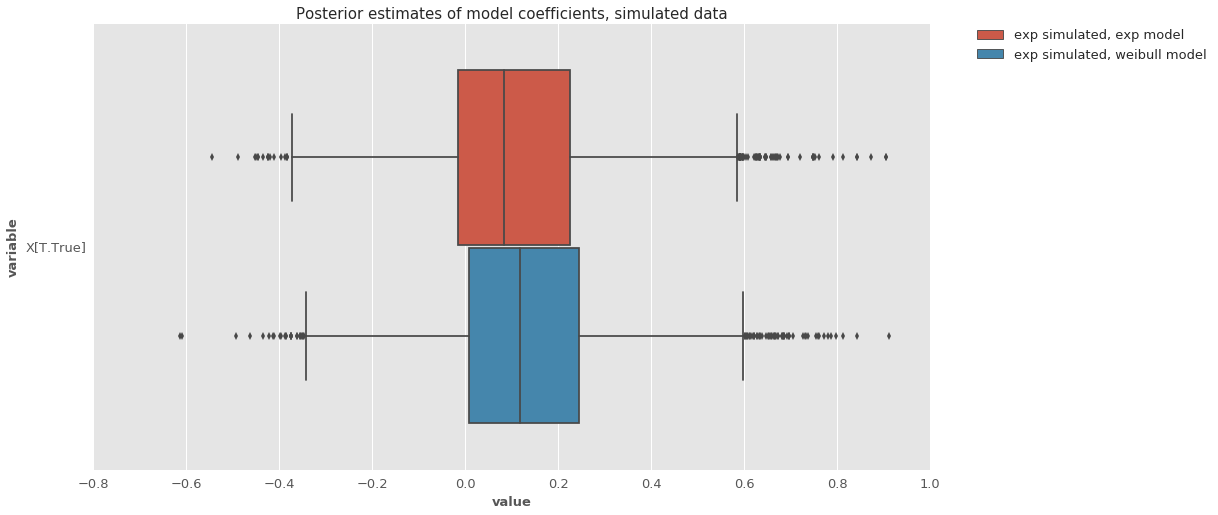

In [19]:
survivalstan.utils.plot_coefs(models = [exp_model, weib_model])
plt.title('Posterior estimates of model coefficients, simulated data', size = 15)

In [20]:
stanity.loo_compare(weib_model['loo'], exp_model['loo'])

{'diff': 0.39328730440969473, 'se_diff': 0.52756534110618469}

Posterior predictive checking

Basic strategy:

1. Compute posterior estimates of y, assuming no censoring
2. For each iteration, summarize proportion of population surviving to time `t`
3. Summarize survival over iterations (requires selecting desired summary timepoints)



In [21]:
## example for exponential model - extract `yhat_uncens` observations
posterior_preds = survivalstan.utils.extract_params_long(models=[exp_model], element='yhat_uncens')
posterior_preds.rename(columns = {'variable': 'index', 'value': 'ppred_t'}, inplace=True)
posterior_preds['ppred_event'] = True
posterior_preds.head()

,iter,index,ppred_t,model_cohort,ppred_event
0,0,0,0.129399,"exp simulated, exp model",True
1,1,0,1.745296,"exp simulated, exp model",True
2,2,0,0.240160,"exp simulated, exp model",True
3,3,0,0.167429,"exp simulated, exp model",True
4,4,0,1.361147,"exp simulated, exp model",True


In [22]:
##  for each iteration, summarize cumulative survival at each observed timepoint
posterior = posterior_preds.groupby(['iter']).apply(
    lambda row: survival_table_from_events(event_observed=row['ppred_event'], death_times=row['ppred_t']),
    )

In [23]:
## rename variables
## (should really be done by model cohort, but ok here since max is same for both groups)
posterior['Survival'] = posterior['at_risk']/max(posterior['at_risk'])
posterior.reset_index(inplace=True)
posterior.head()

,iter,event_at,removed,observed,censored,entrance,at_risk,Survival
0,0,0.000000,0.0,0.0,0.0,100.0,100.0,1.00
1,0,0.001416,1.0,1.0,0.0,0.0,100.0,1.00
2,0,0.002300,1.0,1.0,0.0,0.0,99.0,0.99
3,0,0.025914,1.0,1.0,0.0,0.0,98.0,0.98
4,0,0.033246,1.0,1.0,0.0,0.0,97.0,0.97


In [24]:
## define time intervals at which we want to summarize estimates
time_bins = np.linspace(0, 10, 100)
posterior['time_interval'] = np.digitize(posterior['event_at'], time_bins)
posterior['interval_t'] = time_bins[posterior['time_interval']-1].astype(float)
posterior.head()

,iter,event_at,removed,observed,censored,entrance,at_risk,Survival,time_interval,interval_t
0,0,0.000000,0.0,0.0,0.0,100.0,100.0,1.00,1,0.0
1,0,0.001416,1.0,1.0,0.0,0.0,100.0,1.00,1,0.0
2,0,0.002300,1.0,1.0,0.0,0.0,99.0,0.99,1,0.0
3,0,0.025914,1.0,1.0,0.0,0.0,98.0,0.98,1,0.0
4,0,0.033246,1.0,1.0,0.0,0.0,97.0,0.97,1,0.0


In [25]:
## for each interval, take last observation in the time interval
ppsummary = posterior.copy()
ppsummary = posterior.sort_values(['iter','time_interval','event_at']).groupby([
        'iter','time_interval'], as_index=False).last()
ppsummary.head()

,iter,time_interval,event_at,removed,observed,censored,entrance,at_risk,Survival,interval_t
0,0,1,0.096138,1.0,1.0,0.0,0.0,89.0,0.89,0.00000
1,0,2,0.200744,1.0,1.0,0.0,0.0,81.0,0.81,0.10101
2,0,3,0.293032,1.0,1.0,0.0,0.0,74.0,0.74,0.20202
3,0,4,0.397739,1.0,1.0,0.0,0.0,67.0,0.67,0.30303
4,0,5,0.491911,1.0,1.0,0.0,0.0,61.0,0.61,0.40404


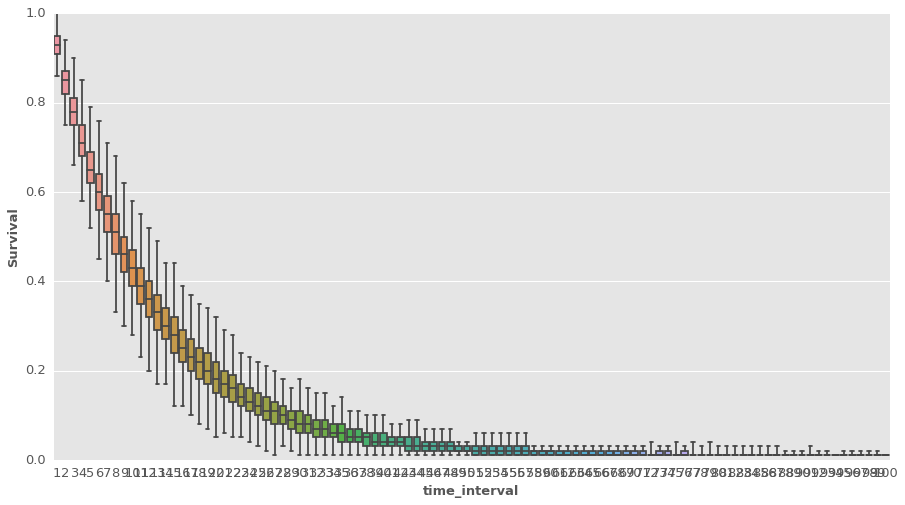

In [26]:
## summarize over intervals 
sb.boxplot(data = ppsummary,
           x = 'time_interval',
           y = 'Survival',
           fliersize=0)

In [27]:
def sum_percentiles(df, percentile, by=['time_interval'], keep_cols = ['time_interval', 'interval_t','Survival']):
    pdata = df.groupby(by, as_index=False).agg(lambda x: np.percentile(x, percentile))
    pdata = pdata.loc[:, keep_cols]
    return(pdata)

p10 = sum_percentiles(ppsummary, percentile=10)
p90 = sum_percentiles(ppsummary, percentile=90)

ppsummary2 = pd.merge(p10, p90, on=['time_interval','interval_t'], suffixes = ['_p10','_p90'])
ppsummary2.head()

,time_interval,interval_t,Survival_p10,Survival_p90
0,1,0.00000,0.89,0.96
1,2,0.10101,0.80,0.90
2,3,0.20202,0.72,0.84
3,4,0.30303,0.65,0.78
4,5,0.40404,0.58,0.72


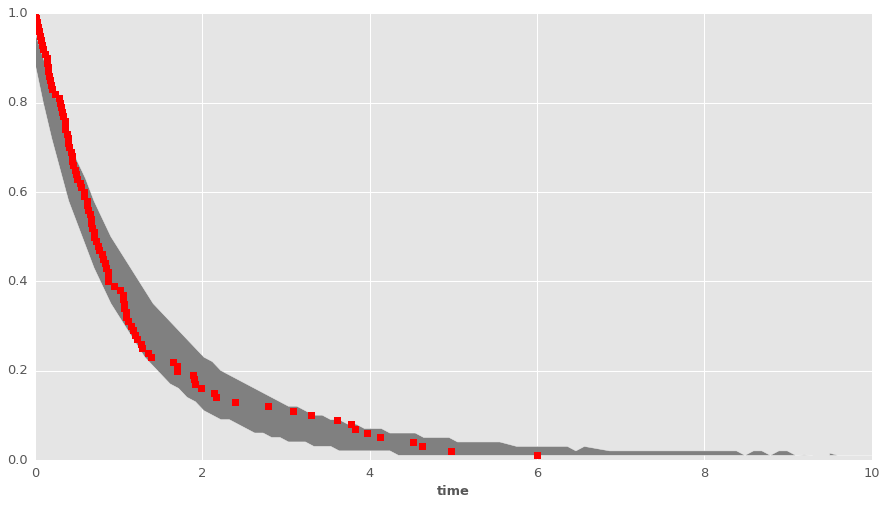

In [28]:
plot_cum_survival(event=df.event, t=df.t)
_ = plt.fill_between(ppsummary2.interval_t,
                     ppsummary2.Survival_p10,
                     ppsummary2.Survival_p90,
                     where= ppsummary2.Survival_p90 >=  ppsummary2.Survival_p10,
                     facecolor='gray')

These checks can be useful, in two ways: 

1. In practice, we don't know the true shape of the baseline hazard.
2. Also, it can help uncover problems in the process of data-simulation and/or estimation.

![example2](https://raw.githubusercontent.com/jburos/biostan-examples/master/weibull-survival-model_files/figure-markdown_github/sim-plot-ppcheck-1.png "Example of posterior predictive check")

[Link to analysis](https://github.com/jburos/biostan-examples/blob/master/weibull-survival-model.md)

![example1](https://raw.githubusercontent.com/jburos/biostan-examples/master/applied-survival-model_files/figure-markdown_github/wei-ppchecks-1.png "Example of posterior predictive check")

[Link to analysis](https://github.com/jburos/biostan-examples/blob/master/applied-survival-model.md)

## Modeling the baseline hazard

There are a variety of methods used to model the baseline hazard.

Parametric:
* Gamma
* exponential
* Weibull

Semi- or non-parametric:
* Gamma, Weibull or exponential *priors* on hazards
* Gamma-process priors
* random-walk priors
* unconstrained piecewise hazard

Often we want to find a way to fit baseline hazards more flexibly, in order to better understand covariate effects.

One approach to this is to use a "binned likelihood". 

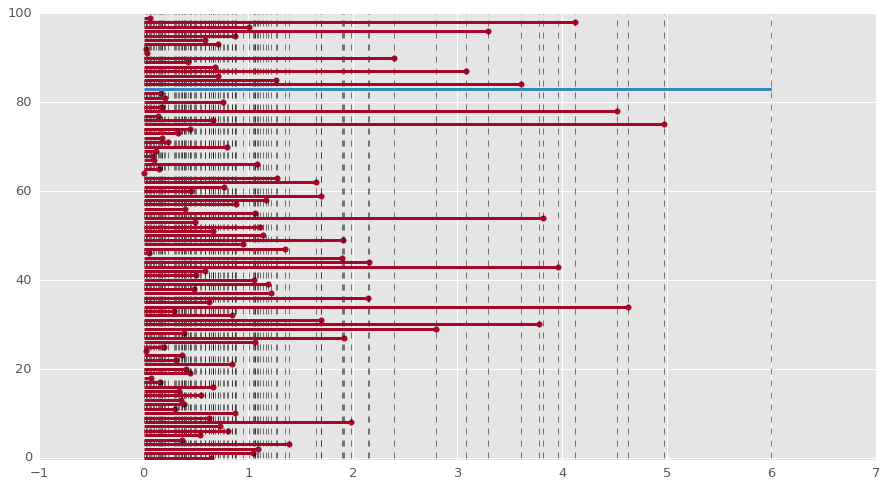

In [29]:
unique_failure_times=df['t'].unique()
for ftime in unique_failure_times:
    plt.vlines(ftime, 0, 100, lw=0.5, linestyles="--")
plot_lifetimes(event_observed=df.event, lifetimes=df.t)

In [30]:
## transform data 
dflong = survivalstan.prep_data_long_surv(df=df.reset_index(), event_col='event', time_col='t')
dflong.sort_values(['t']).head()

,index,X,baseline_hazard,hazard,true_t,t,event,key,end_time,end_failure
3535,35,True,0.9,1.099262,0.004904,0.004904,True,1,0.004904,True
7535,75,True,0.9,1.099262,0.018886,0.018886,True,1,0.004904,False
7575,75,True,0.9,1.099262,0.018886,0.018886,True,1,0.018886,True
775,7,False,0.9,0.900000,0.023054,0.023054,True,1,0.018886,False
707,7,False,0.9,0.900000,0.023054,0.023054,True,1,0.023054,True


In [31]:
## fit unstructured-hazard model to these data
pem_unstr = survivalstan.fit_stan_survival_model(df = dflong, 
                                                 formula = '~ X',
                                                 event_col = 'end_failure',
                                                 timepoint_end_col = 'end_time',
                                                 sample_col = 'index',
                                                 model_code = models['pem_survival_model_unstructured.stan'],
                                                 chains = 4, 
                                                 iter = 1000,
                                                 model_cohort = 'exp simulated, unstructured hazard',
                                                )

NOT reusing model.
Ran in 97.042 sec.


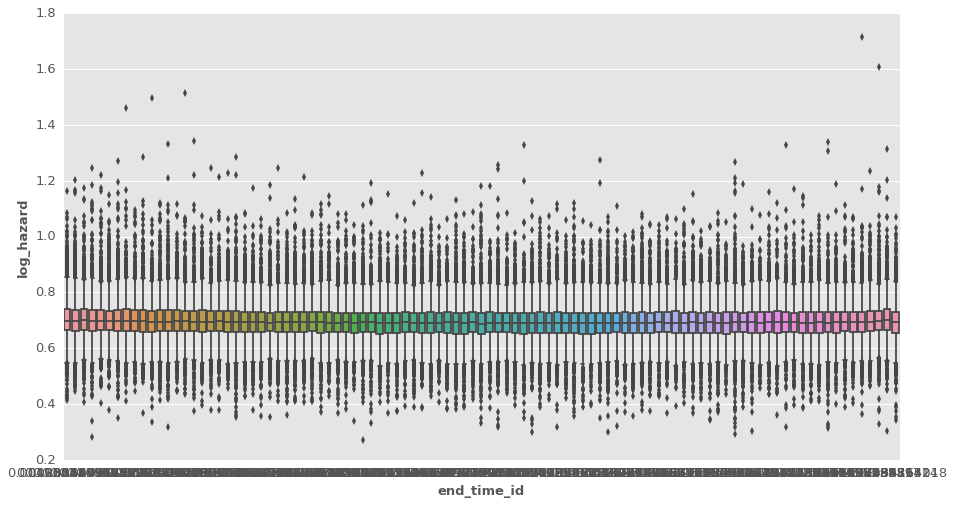

In [32]:
survivalstan.utils.plot_coefs([pem_unstr], element='baseline_raw')

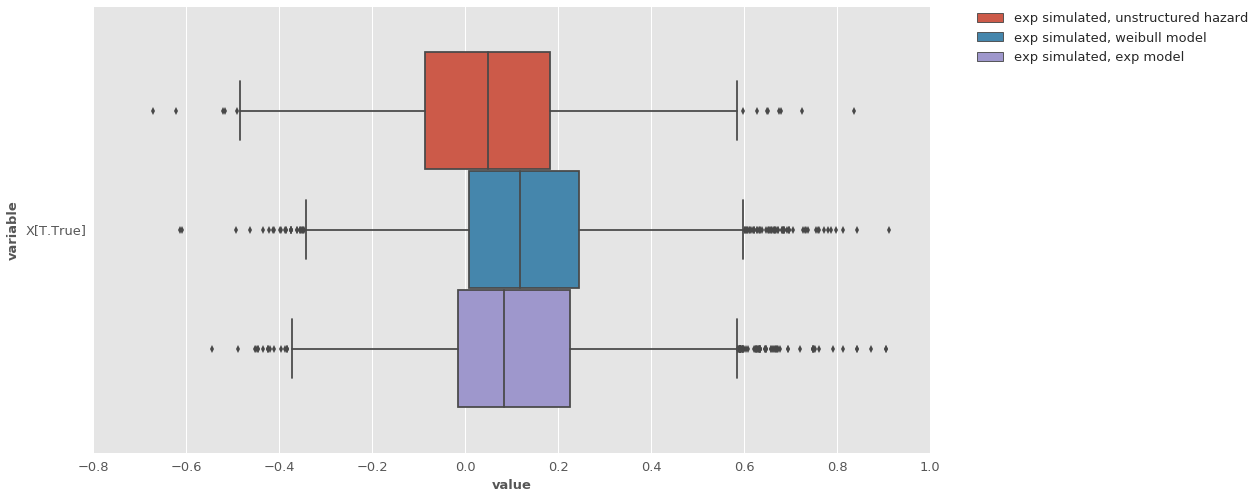

In [33]:
survivalstan.utils.plot_coefs([pem_unstr, weib_model, exp_model])

In [34]:
## fit randomwalk-prior model to these data
pem_randomwalk = survivalstan.fit_stan_survival_model(df = dflong, 
                                                 formula = '~ X',
                                                 event_col = 'end_failure',
                                                 timepoint_end_col = 'end_time',
                                                 sample_col = 'index',
                                                 model_code = models['pem_survival_model_randomwalk.stan'],
                                                 chains = 1, 
                                                 iter = 5000,
                                                 model_cohort = 'exp simulated, random walk prior hazard'
                                                )

NOT reusing model.
Ran in 552.588 sec.


The resulting `baseline_raw` hazard estimates from this model reflect the structure we imposed on the sample -- recall that we only have a sample size of `n=100`.

In this model, our baseline hazard has an overall mean (`log_baseline_mu`) and the deviance from that mean is allowed to vary from one timepoint to the next.

Let's see what this looks like in practice:


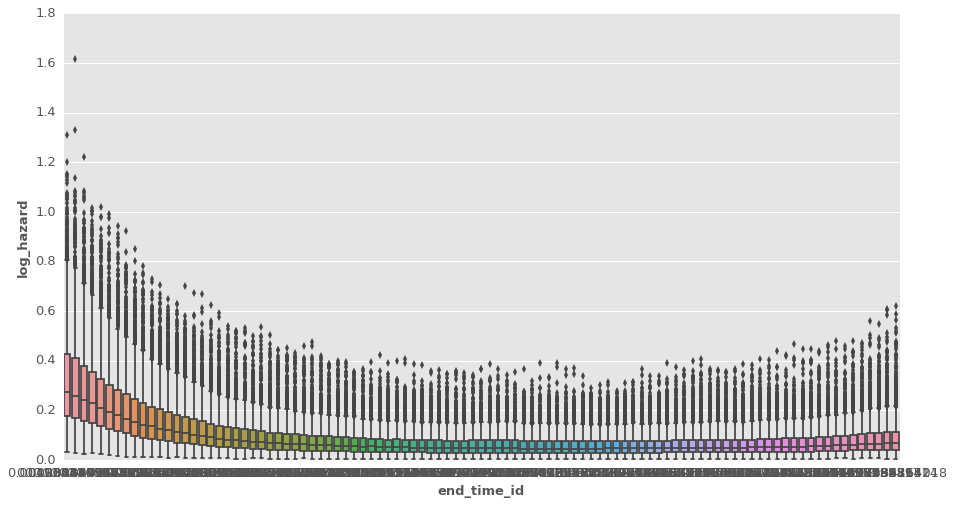

In [35]:
survivalstan.utils.plot_coefs([pem_randomwalk], element='baseline_raw')

Now, a perhaps the more important question is how this variance in our baseline hazard impacts our coefficient estimates. 

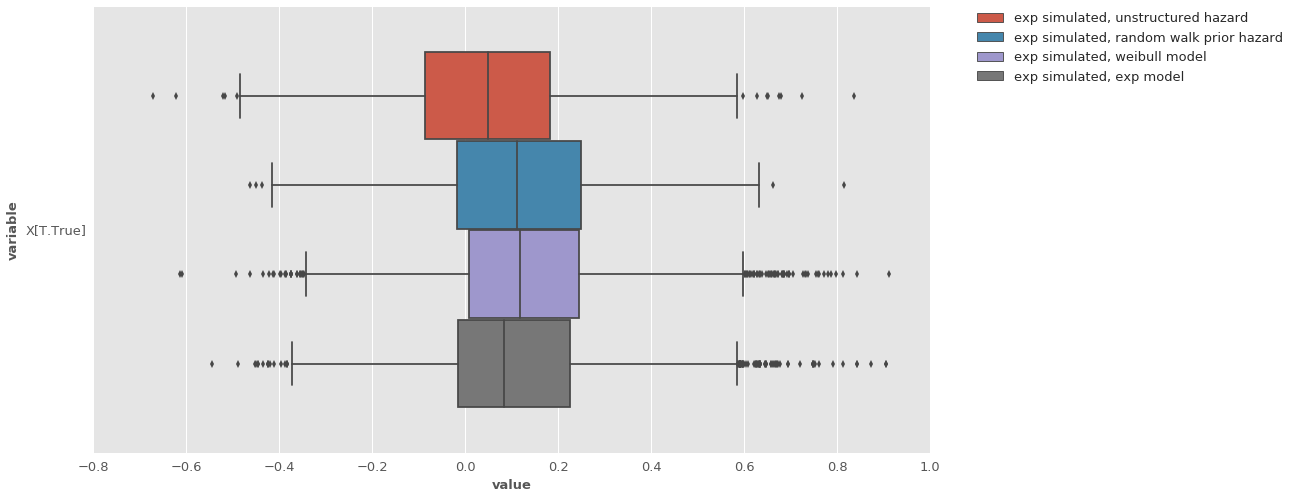

In [36]:
survivalstan.utils.plot_coefs([pem_unstr, pem_randomwalk, weib_model, exp_model])

In general, it appears that these models behave very similarly -- which is good. 

Let's compare to the "True" beta (the value used to simulate the data) of 0.2.

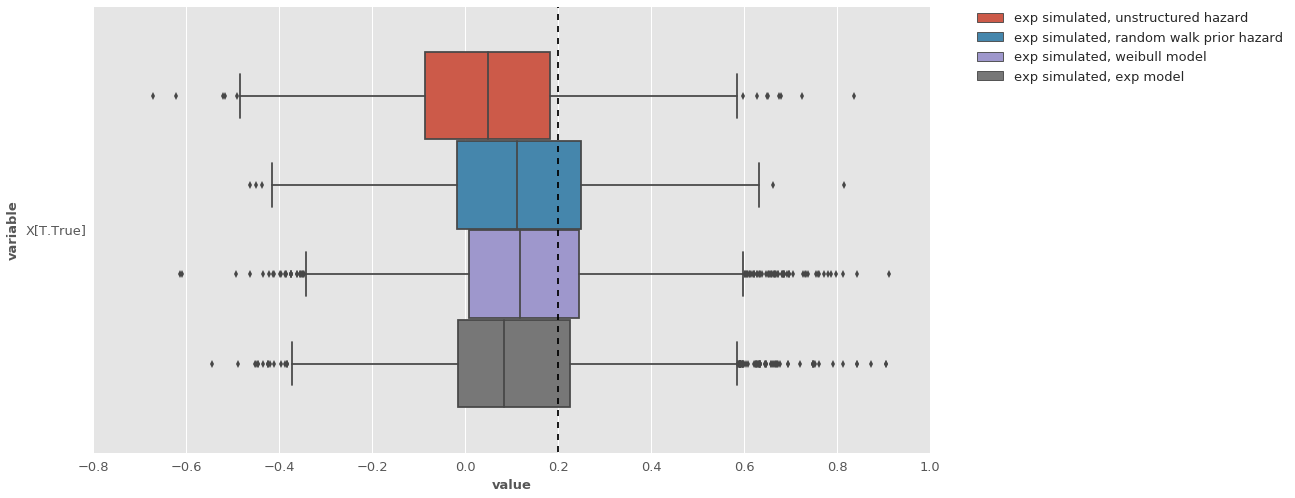

In [37]:
survivalstan.utils.plot_coefs([pem_unstr, pem_randomwalk, weib_model, exp_model])
plt.vlines(0.2, -200, 200, linestyles='--')

Compare model fit with unstructured baseline hazard to that with random walk.  Is there a difference between the two models according to PSIS-LOO? 

In [38]:
stanity.loo_compare(pem_unstr['loo'], pem_randomwalk['loo'])

{'diff': 6.7186238987099252, 'se_diff': 5.0038264166095843}

For this model, we wouldn't expect a strong difference between these two models, since the true hazard we used to simulate the data did not vary over time. In practice, hazards can and sometimes do vary over time. 

One of the challenges of survival analysis in practice, particularly with small sample sizes, is to *stabilize the estimates of the baseline hazard*, since our inferences for coefficient effects are multiplicative on this hazard.

In a companion notebook, we work through a process for analyzing data from [TCGA](https://tcga-data.nci.nih.gov/tcga/tcgaCancerDetails.jsp?diseaseType=BLCA&diseaseName=Bladder Urothelial Carcinoma), focusing on the BLCA cohort.